In [128]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from scipy.fft import fft, fftfreq

current_path = os.path.abspath('.')

In [129]:
# Functions
def structure_file(df, test=False):
    if not test:
        df = df[0].str.split('\t', n=4, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z"]
    else:
        df = df[0].str.split('\t', n=5, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z", "labels"]
    
    GYR_data = df.loc[df['sensor'] == 'GYR']
    ACC_data = df.loc[df['sensor'] == 'ACC']

    GYR_data.index = GYR_data['time'].apply(pd.to_numeric)
    ACC_data.index = ACC_data['time'].apply(pd.to_numeric)
    GYR_data = GYR_data.drop('sensor', axis=1)
    ACC_data = ACC_data.drop('sensor', axis=1)
    if not test:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z"]
    else:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z", "label"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z", "drop_label"]
        ACC_data = ACC_data.drop("drop_label", axis=1)
    min_idx = np.argmin([ACC_data.shape[0], GYR_data.shape[0]]) 
    max_idx = np.argmax([ACC_data.shape[0], GYR_data.shape[0]])  

    data_acc_gyr = [ACC_data, GYR_data] 
    data_acc_gyr[max_idx] = data_acc_gyr[max_idx].reindex(data_acc_gyr[min_idx].index, method='nearest', tolerance=0.02)
    new_set = pd.concat(data_acc_gyr, axis=1)
    pandas_data = new_set.dropna().reset_index(drop=True)
    pandas_data = pandas_data.apply(pd.to_numeric)
    return pandas_data

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

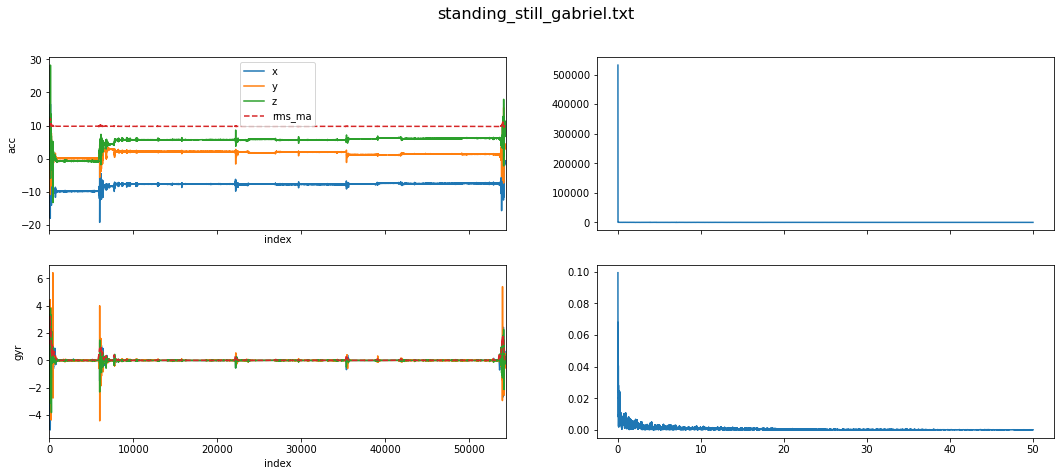

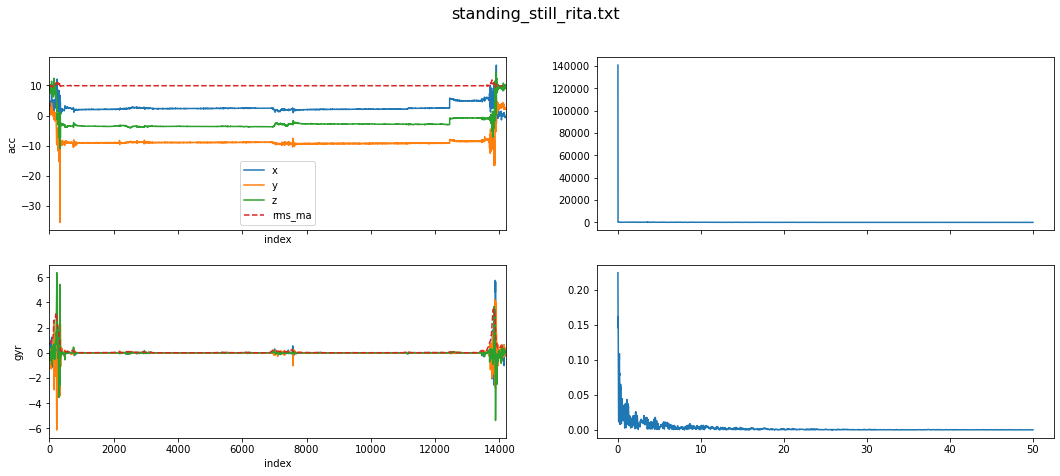

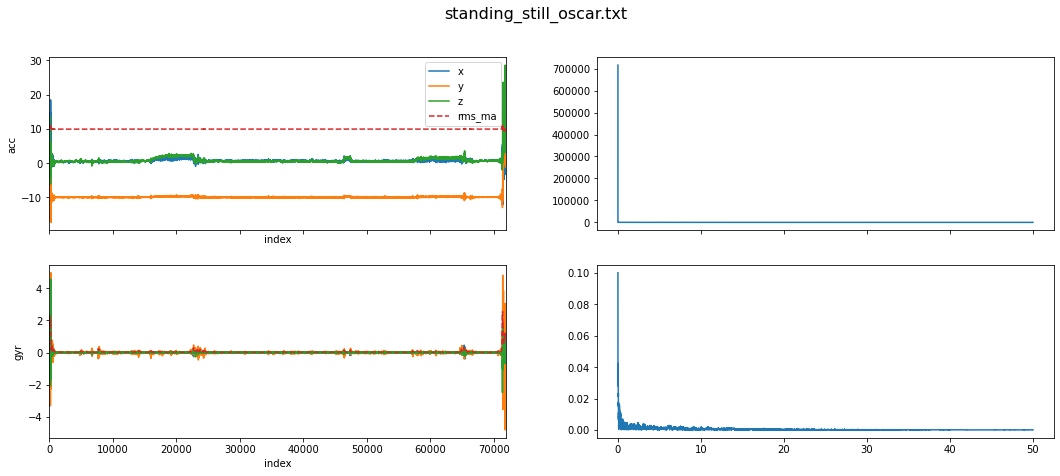

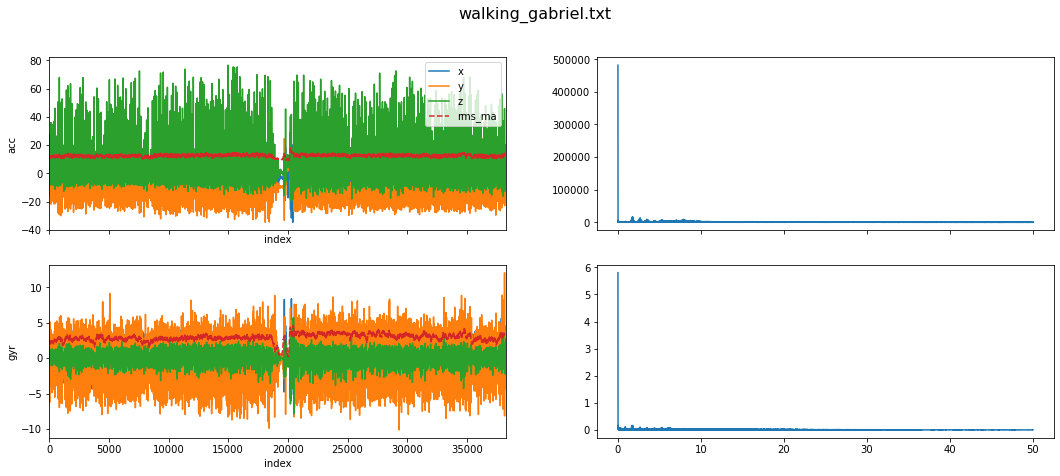

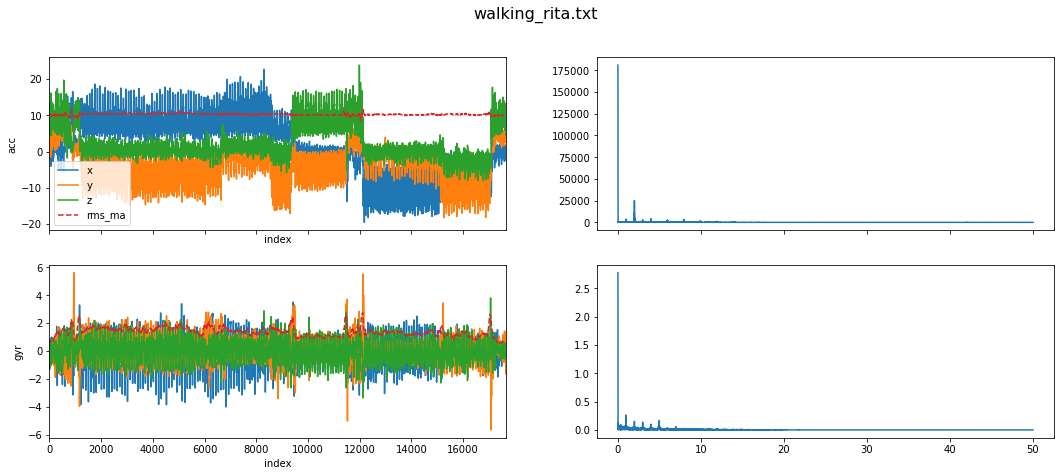

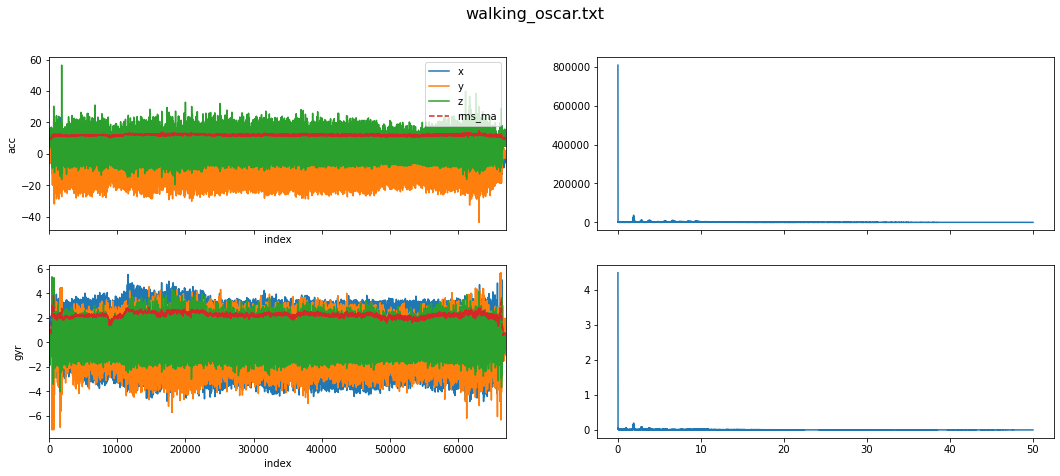

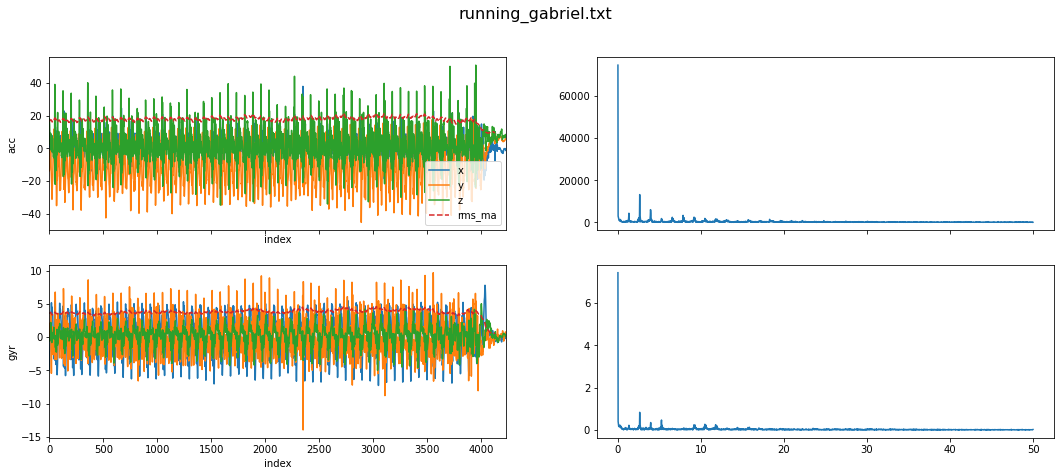

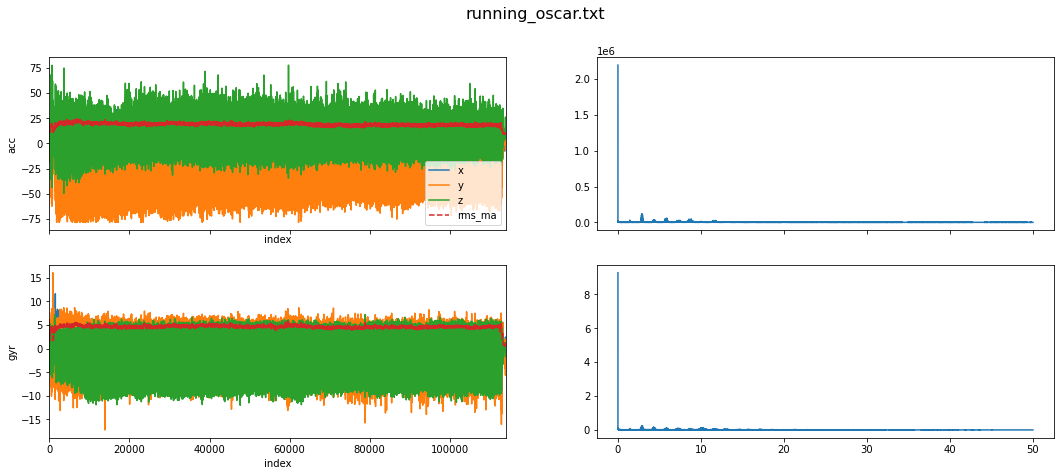

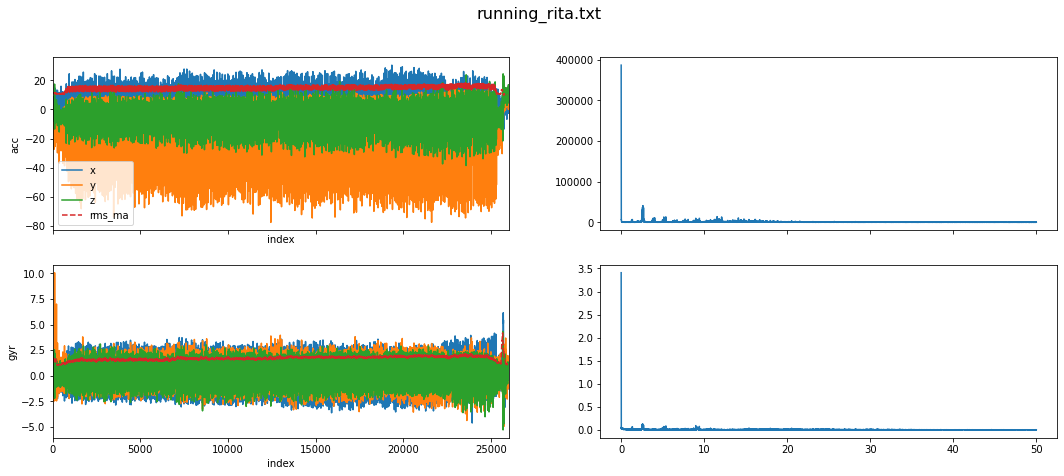

In [130]:
data_types = ["standing_still", "walking", "running"]

for data_type in data_types:
    data_path = os.path.join(current_path, data_type)
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        data = pd.read_csv(file_path, header=None)
        pandas_data = structure_file(data)
        # pprint(pandas_data)

        # Compute rms
        rms_acc = np.sqrt(pandas_data['acc_x']**2 + pandas_data['acc_y']**2 + pandas_data['acc_z']**2).to_numpy(dtype=float, copy=True)
        rms_gyr = np.sqrt(pandas_data['gyr_x']**2 + pandas_data['gyr_y']**2 + pandas_data['gyr_z']**2).to_numpy(dtype=float, copy=True)

        # Compute moving average
        rms_acc_ma = moving_average(rms_acc, int(1/0.01))
        rms_gyr_ma = moving_average(rms_gyr, int(1/0.01))

        # Compute fft
        N = len(rms_acc)  # number of sample points
        T = 0.01  # sampling time

        fft_acc = fft(rms_acc)
        fft_gyr = fft(rms_gyr)
        xf = fftfreq(N, T)[:N // 2]

        # Plot data
        fig, ax = plt.subplots(2, 2, sharex='col', figsize=(18, 7))
        fig.suptitle(file, fontsize=16)
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_x']), label='x')
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_y']), label='y')
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_z']), label='z')
        ax[0,0].plot(rms_acc_ma, '--', label='rms_ma')
        ax[0,0].set_xlabel('index')
        ax[0,0].set_ylabel('acc')
        ax[0,1].plot(xf, np.abs(fft_acc[0:N // 2]))
        ax[0,0].margins(x=0)
        ax[0,0].legend()
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_x']), label='x')
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_y']), label='y')
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_z']), label='z')
        ax[1,0].plot(rms_gyr_ma, '--', label='rms_ma')
        ax[1,0].set_xlabel('index')
        ax[1,0].set_ylabel('gyr')
        ax[1,0].margins(x=0)
        ax[1,1].plot(xf, 2.0/N * np.abs(fft_gyr[0:N // 2]))
        plt.show()



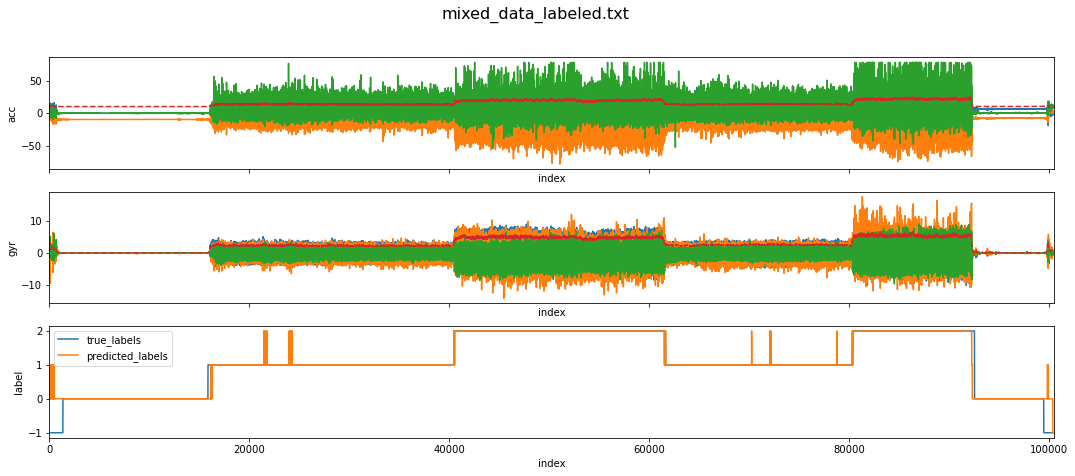

In [131]:
# Testing threshold
file = "mixed_data_labeled.txt"
file_path = os.path.join(current_path, "test_data", file)
data = pd.read_csv(file_path, header=None)
pandas_data = structure_file(data, test=True)

# Compute rms
rms_acc = np.sqrt(pandas_data['acc_x']**2 + pandas_data['acc_y']**2 + pandas_data['acc_z']**2).to_numpy(dtype=float, copy=True)
rms_gyr = np.sqrt(pandas_data['gyr_x']**2 + pandas_data['gyr_y']**2 + pandas_data['gyr_z']**2).to_numpy(dtype=float, copy=True)

# Compute moving average
rms_acc_ma = moving_average(rms_acc, int(1/0.01))
rms_gyr_ma = moving_average(rms_gyr, int(1/0.01))

# Define labels (other=-1, standing_still=0, walking=1, running=2)
walking_thres = 11
running_thres = 15
true_labels = np.array(pandas_data['label'])
predicted_labels = -np.ones_like(true_labels)
predicted_labels[np.argwhere(rms_acc_ma < walking_thres)] = 0
predicted_labels[np.argwhere((rms_acc_ma > walking_thres) & (rms_acc_ma < running_thres))] = 1
predicted_labels[np.argwhere(rms_acc_ma > running_thres)] = 2

# Plot data
fig, ax = plt.subplots(3, 1, sharex='col', figsize=(18, 7))
fig.suptitle(file, fontsize=16)
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_x']), label='x')
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_y']), label='y')
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_z']), label='z')
ax[0].plot(rms_acc_ma, '--', label='rms_ma')
ax[0].set_xlabel('index')
ax[0].set_ylabel('acc')
ax[0].margins(x=0)
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_x']), label='x')
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_y']), label='y')
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_z']), label='z')
ax[1].plot(rms_gyr_ma, '--', label='rms_ma')
ax[1].set_xlabel('index')
ax[1].set_ylabel('gyr')
ax[1].margins(x=0)
ax[2].plot(pandas_data.index, true_labels, label='true_labels')
ax[2].plot(pandas_data.index, predicted_labels, label='predicted_labels')
ax[2].set_xlabel('index')
ax[2].set_ylabel('label')
ax[2].margins(x=0)
plt.legend()
plt.show()